In [1]:
import torch
import torch.distributions as tdis
import numpy as np
import pandas as df
from collections import defaultdict
from datetime import datetime as dt, timedelta as tdelta

In [5]:
class DatasetCreator(object):
    def __init__(self, temperature_file="./temp_data.csv", seed=71):
        self.temperature_file = temperature_file
        self.seed = seed
        self.food_cate_list = ["korean", "western", "chinese", "japanese", "vietnam", "indian", "mexican"]
        self.food_dict = {
            "chinese": ["black bean sauce noodle", "fried rice", "hotpot(huoguo)"], 
            "indian": ["curry rice"], 
            "western": ["pasta", "pizza", "fried chicken", "hamburger", "steak", "hotdog"], 
            "korean": ["korean bbq", "kimchi stew", "soybean paste stew","cold noodles", "bibimbap"],
            "mexican" : ["taco", "burrito"],
            "japanese": ["sushi", "donkatsu"],
            "vietnam": ["pho", "banh mi thit"]
        }
        self.workload_dict = {0: "No work", 1: "Low", 2: "Normal", 3: "High"}
        
        # all probs
        self.food_cate_probs = [0.27, 0.19, 0.19, 0.16, 0.08, 0.08, 0.03]
        self.hometime_probs = [0.6, 0.2, 0.1, 0.07, 0.03]  # 6, 7, 8, 9, 10
        self.workload_probs = [0.15, 0.70, 0.15]
        self.earlymeeting_probs = [0.25]
        # self.create_distributions(seed)
        # create datas
        # self.create_data(start_date, end_date, fmt, seed, save_path)
        
    def create_distributions(self):
        torch.manual_seed(self.seed)
        # temperature distrubution
        with open(temperature_file, "r") as file:
            temp_data = [x.strip("\n").split(",") for x in file.readlines()[1:]]
            temp_data = [(int(date.split("-")[1]), float(temp)) for date, temp in temp_data]
        self.temperature_data = defaultdict(list)
        for month, temp in temp_data:
             self.temperature_data[month].append(temp)
        self.temperature_statics = {month: (np.mean(temp), np.std(temp)) for month, temp in self.temperature_data.items()}
        self.temperature_dis = {month: tdis.Normal(loc=torch.FloatTensor([mean]), 
                                                     scale=torch.FloatTensor([std])) 
                                for month, (mean, std) in self.temperature_statics.items()}
        # hometime distribution
        self.hometime_dis = tdis.Categorical(probs=torch.FloatTensor(self.hometime_probs))
        # workload distribution
        self.workload_dis = tdis.Categorical(probs=torch.FloatTensor(self.workload_probs))
        # earlymeeting distribution
        self.earlymeeting_dis = tdis.Bernoulli(probs=torch.FloatTensor(self.earlymeeting_probs))
        # food distribution
        self.food_cate_dis = tdis.Categorical(probs=torch.FloatTensor(self.food_cate_probs))
        self.food_dis = {
            cate: tdis.Categorical(torch.softmax(torch.randn(len(self.food_dict[cate])), dim=0)) \
                for cate in self.food_cate_list
        }
        
    def create_data(self, start_date="2020-01-01", end_date="2020-12-31", fmt="%Y-%m-%d", save_path="./dinner_records.csv"):
        torch.manual_seed(self.seed)
        s, e = dt.strptime(start_date, fmt), dt.strptime(end_date, fmt)
        total_days = (e-s).days
        dates = np.array([dt.strftime(s + tdelta(days=i), fmt) for i in range(total_days)])
        business_dindex = torch.BoolTensor([np.is_busday(d) for d in dates])
        
        # sample temperatures
        temperatures = 0.4*np.array([self.temperature_dis[int(day.split("-")[1])].loc.item() + 1.5*
            self.temperature_dis[int(day.split("-")[1])].sample((1,)).item() for day in dates
        ])
        # sample hometime_hours
        hometime_hours = self.hometime_dis.sample((total_days,)) + 6
        hometime_hours[~business_dindex] = 0
        hometime_hours = hometime_hours.numpy()
        
        # sample workloads
        workloads = self.workload_dis.sample((total_days,)) + 1
        workloads[~business_dindex] = 0
        workloads = np.array([self.workload_dict.get(x.item()) for x in workloads])
        
        # sample earlymeetings
        earlymeetings = self.earlymeeting_dis.sample((total_days,)).type(torch.int).view(-1)
        earlymeetings[~business_dindex] = 0
        earlymeetings = earlymeetings.numpy()
        # sample foods
        foods_cates = []
        foods = []
        for sampled_cate in self.food_cate_dis.sample((total_days,)):
            cate = self.food_cate_list[sampled_cate]
            foods_cates.append(cate)
            sampled_food = self.food_dict[cate][self.food_dis[cate].sample((1,))]
            foods.append(sampled_food)
        header = np.array(["temperature", "hometime", "workload", "earlymeeting", "food_cate", "food"])[np.newaxis, :]
        final_data = np.array([temperatures, hometime_hours, workloads, earlymeetings, foods_cates, foods]).T
        np.savetxt(save_path, np.concatenate((header, final_data)), fmt="%s", delimiter=",")

In [211]:
start_date="2018-01-01"
end_date="2020-06-01"
fmt="%Y-%m-%d"
temperature_file="./temp_data.csv"
save_path="./dinner_records_all.csv"
save_path_train="./dinner_records_train.csv"
save_path_test="./dinner_records_test.csv"
seed = 5
food_record_creator = DatasetCreator(temperature_file, seed)
food_record_creator.create_distributions()
food_record_creator.create_data(start_date, end_date, fmt, save_path)

In [212]:
d = 31+29+31+30+31
df = pd.read_csv(save_path)
df_train = df.iloc[:-d, :]
df_test = df.iloc[-d:, :]
df_train.to_csv(save_path_train, index=False)
df_test.to_csv(save_path_test, index=False)

In [213]:
df_train = pd.read_csv(save_path_train)
df_test = pd.read_csv(save_path_test)
df = pd.read_csv(save_path)

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
df_list = [df, df_train, df_test]
title_list = [f"all data", f"train data (# of data: {len(df_train)})", f"test data (# of data: {len(df_test)})"]

C:\Users\simon\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\simon\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


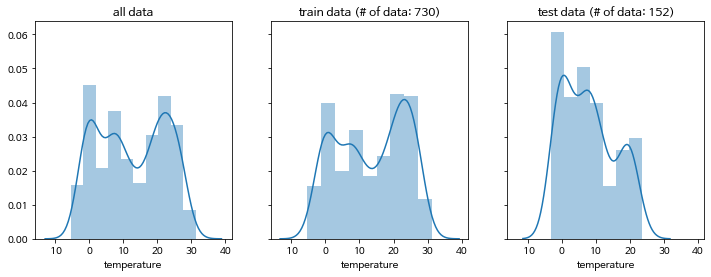

In [216]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharey=True, sharex=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.distplot(data["temperature"], ax=ax)
    ax.set_title(title, fontsize=12)

C:\Users\simon\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\simon\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


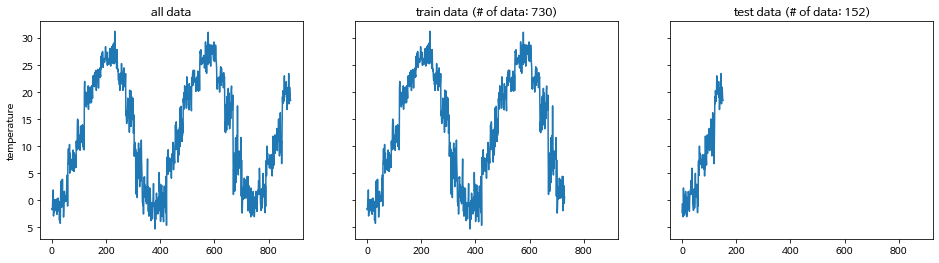

In [217]:
fig, axes = plt.subplots(1, len(df_list), figsize=(16, 4), sharey=True, sharex=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.lineplot(x=data.index, y=data["temperature"], ax=ax)
    ax.set_title(title, fontsize=12)

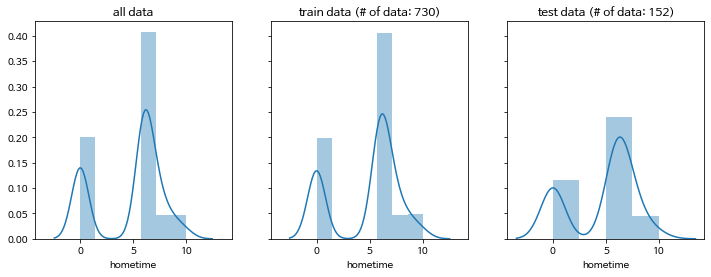

In [218]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharey=True, sharex=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.distplot(data["hometime"], ax=ax)
    ax.set_title(title, fontsize=12)

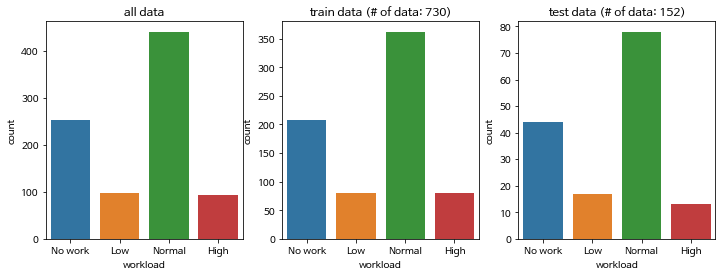

In [245]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharex=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.countplot(data["workload"], ax=ax, order=food_record_creator.workload_dict.values())
    ax.set_title(title, fontsize=12)

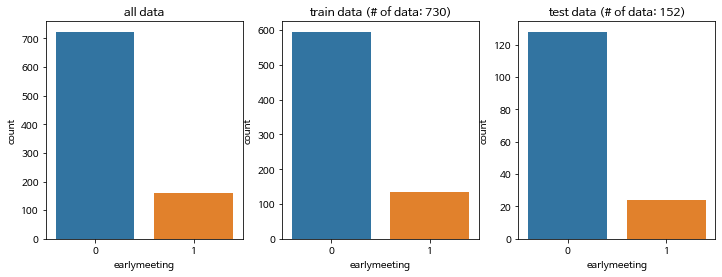

In [246]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharex=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.countplot(data["earlymeeting"], ax=ax)
    ax.set_title(title, fontsize=12)

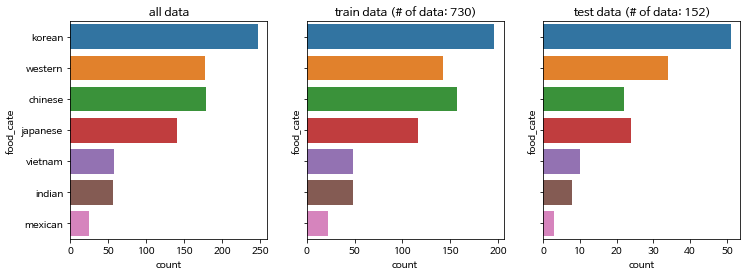

In [247]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharey=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.countplot(y=data["food_cate"], ax=ax, order=food_record_creator.food_cate_list)
    ax.set_title(title, fontsize=12)

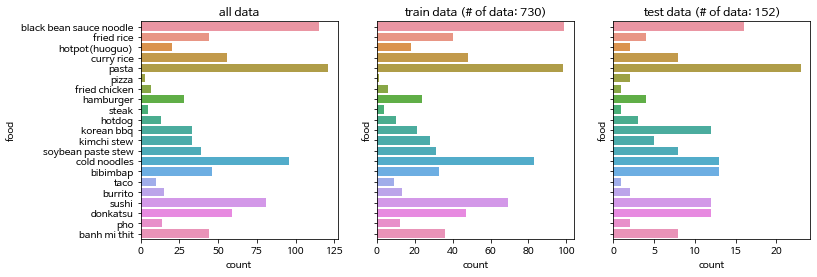

In [250]:
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 4), sharey=True)
for ax, data, title in zip(axes, df_list, title_list):
    sns.countplot(y=data["food"], ax=ax, order=[y for x in list(food_record_creator.food_dict.values()) for y in x])
    ax.set_title(title, fontsize=12)